## Predicting Dog Adoption

In [653]:
import pandas as pd
import numpy
import datetime
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
#Metrics
from sklearn.metrics import accuracy_score

In [666]:
#read in intake data
df1=pd.read_csv('intakes.csv').set_index(['Animal ID'])
df1['DateTime']= pd.to_datetime(df1['DateTime'])
for col in ['Intake Condition', 'Animal Type', 'Sex upon Intake']:
    df1[col] = df1[col].astype('category')

In [667]:
#read in outcomes data
df2=pd.read_csv('outcomes.csv').set_index(['Animal ID'])
df2['DateTime']= pd.to_datetime(df2['DateTime']) 
for col in ['Outcome Type', 'Animal Type', 'Sex upon Outcome', 'Outcome Subtype']:
    df2[col] = df2[col].astype('category')

In [675]:
#join intakes to outcomes
df3=pd.merge(df1, df2, on=['Animal ID', 'Color', 'Animal Type', 'Breed', 'Name'], how='right')

In [676]:
#convert to datetime
df3['diff_days'] = df3['DateTime_x'] - df3['DateTime_y']
df3['diff_days']=df3['diff_days']/np.timedelta64(1,'D')
#df3.head()

In [677]:
#filter on rows for just dogs
dfdog=df3[ (df3['Animal Type'] == "Dog") ]

In [678]:
#Find the top 10 breeds
n = 20
top10name = dfdog['Breed'].value_counts()[:n].index.tolist()
topnum = dfdog['Breed'].value_counts()[:n].values.tolist()
top10 = {k: v for k, v in zip(top10name, topnum)}

# Iterate over key/value pairs in dict and print them
for key, value in top10.items():
    print(key, ' : ', value)

Pit Bull Mix  :  14064
Labrador Retriever Mix  :  9635
Chihuahua Shorthair Mix  :  7589
German Shepherd Mix  :  4104
Australian Cattle Dog Mix  :  1967
Rat Terrier Mix  :  1855
Boxer Mix  :  1410
Border Collie Mix  :  1320
Dachshund Mix  :  1244
Staffordshire Mix  :  1227
Pit Bull  :  1177
Miniature Poodle Mix  :  1150
German Shepherd  :  1108
Siberian Husky Mix  :  1011
Labrador Retriever  :  1011
Catahoula Mix  :  995
Chihuahua Shorthair  :  926
Australian Shepherd Mix  :  836
Pointer Mix  :  804
Beagle Mix  :  767


In [679]:
#filter down to owner surrendered dogs and those of the top ten breeds.
dfdog = dfdog[dfdog['Breed'].isin(top10name)]

#convert the age into weeks
dfdog['age'], dfdog['unit'] = dfdog['Age upon Intake'].str.split(' ', 1).str
dfdog=dfdog.drop(columns=['Age upon Intake'])
tconversion = {'year': 52,'years': 52, 'month': 4, 'months': 4, 'week': 1, 'weeks': 1, 'day': 0.14, 'days': 0.14} 
dfdog['unit'] = dfdog['unit'].replace(tconversion, regex=True)
dfdog['age'] = dfdog['age'].astype('float')
dfdog['unit'] = dfdog['unit'].astype('float')
dfdog['age_weeks'] = dfdog['unit']*dfdog['age']

In [694]:
dfdog = dfdog[~dfdog.index.duplicated()]
dfdog.dropna(how='any', inplace=True)

In [754]:
dfdog['TF'] = ((dfdog['diff_days'] < 365) 
               #& (dfdog['diff_days'] >= 0) 
               #& (dfdog['Outcome Type'] == 'Adoption') 
               #& (dfdog['Outcome Subtype'] != "Foster")
               & (dfdog['age_weeks'] > 52))

In [755]:
y=dfdog['TF']
X=dfdog[['Breed', 'age_weeks']]

print('X', X.shape)
print('X', y.shape)

X (7086, 2)
X (7086,)


In [756]:
df_dummiesLabel = pd.get_dummies(y, prefix_sep='', prefix='d')
df_dummies = X['Breed'].str.get_dummies(sep = "/")

In [757]:
df_dummies = pd.concat([df_dummies, X['age_weeks']], axis=1)

In [758]:
y=df_dummiesLabel['dTrue']
X=df_dummies 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X= scaler.fit_transform(X)

print('means (age_weeks): ', X.mean(axis=0))
print('std (age_weeks): ', X.std(axis=0))

means (age_weeks):  [0.03993791 0.0151002  0.01524132 0.02413209 0.02624894 0.01834603
 0.02003951 0.18190799 0.02681343 0.01524132 0.07084392 0.01975727
 0.17809766 0.02032176 0.03245837 0.23652272 0.01383009 0.01749929
 0.01241885 0.01524132 0.14898231]
std (age_weeks):  [0.19581335 0.12195155 0.12251132 0.15345922 0.15987475 0.13419932
 0.14013541 0.38576868 0.16153784 0.12251132 0.25656394 0.13916508
 0.38259493 0.1410985  0.17721406 0.42494673 0.11678534 0.13112234
 0.11074577 0.12251132 0.16864448]


In [759]:
#Confirm X and y
print(y.shape)
print(X.shape)

(7086,)
(7086, 21)


In [760]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=100)

In [761]:
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [762]:
# import the metrics class
#Regression 
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf = cnf_matrix.tolist()
print(cnf_matrix)

[[844   6]
 [  3 919]]


In [763]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.994920993227991


# Other Accuracy Metrics

In [771]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc, false_positive_rate, true_positive_rate)
#This is terrible!

0.5 [0. 1.] [0. 1.]


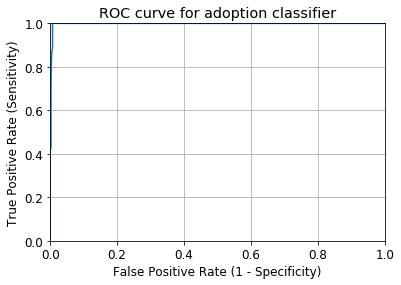

In [772]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adoption classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

The above graph shows a ROC curve that is almost flat to the diagonal - Not Sensitive/Specific enough

In [773]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [774]:
evaluate_threshold(0.7)

Sensitivity: 0.6475054229934925
Specificity: 0.9976470588235294


AUC Scores

In [775]:
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.9945350974445997